In [1]:
from src.luxai_s3.wrappers import LuxAIS3GymEnv
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
import math
from collections import deque
from torch.distributions import Categorical
from tqdm import tqdm
import matplotlib.pyplot as plt

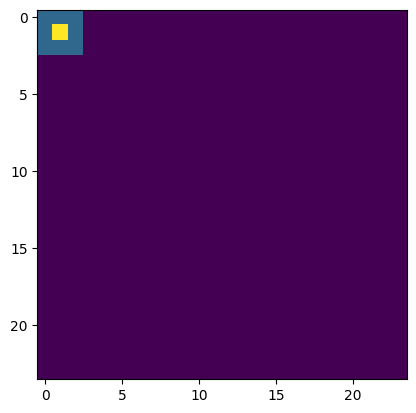

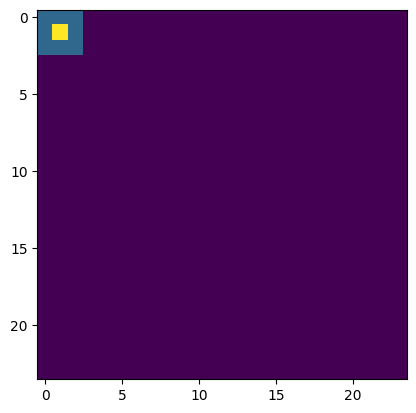

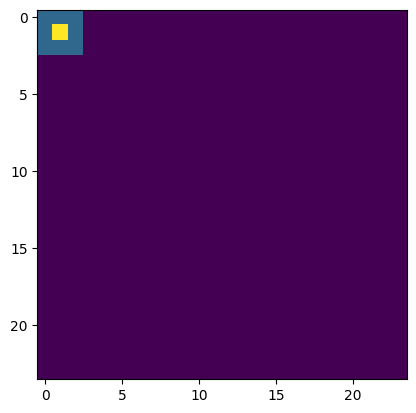

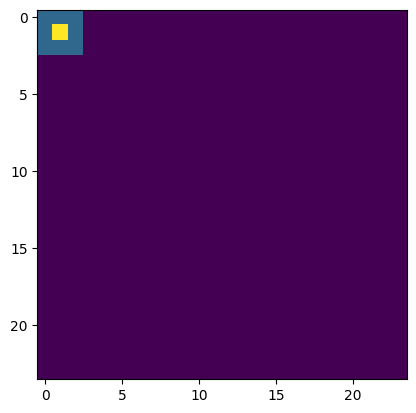

KeyboardInterrupt: 

In [ ]:

for i in range(10):
    env = LuxAIS3GymEnv(numpy_output=True)
    obs,_ = env.reset()
    for i in range(20) :
        action = dict(
                    player_0=np.random.randint(0,4,size=(env.env_params.max_units, 3)),
                    player_1=np.random.randint(0,4,size=(env.env_params.max_units, 3))
                )
        obs, reward, terminated, truncated, info = env.step(action)

    plt.imshow(obs['player_0']['map_features']['tile_type'])
    plt.show()

In [ ]:
env = LuxAIS3GymEnv(numpy_output=True)
ref = env.env_params
print(ref)
for _ in range(10) :
    obs,_ = env.reset()
    print(env.env_params)



EnvParams(max_steps_in_match=100, map_type=1, map_width=24, map_height=24, num_teams=2, match_count_per_episode=5, max_units=16, init_unit_energy=100, min_unit_energy=0, max_unit_energy=400, unit_move_cost=2, spawn_rate=3, unit_sap_cost=10, unit_sap_range=4, unit_sap_dropoff_factor=0.5, unit_energy_void_factor=0.125, max_energy_nodes=6, max_energy_per_tile=20, min_energy_per_tile=-20, max_relic_nodes=6, relic_config_size=5, fog_of_war=True, unit_sensor_range=2, nebula_tile_vision_reduction=1, nebula_tile_energy_reduction=0, nebula_tile_drift_speed=-0.05, energy_node_drift_speed=0.02, energy_node_drift_magnitude=5)
EnvParams(max_steps_in_match=100, map_type=1, map_width=24, map_height=24, num_teams=2, match_count_per_episode=5, max_units=16, init_unit_energy=100, min_unit_energy=0, max_unit_energy=400, unit_move_cost=4, spawn_rate=3, unit_sap_cost=46, unit_sap_range=4, unit_sap_dropoff_factor=0.5, unit_energy_void_factor=0.125, max_energy_nodes=6, max_energy_per_tile=20, min_energy_per_

In [2]:
env = LuxAIS3GymEnv(numpy_output=True)
obs,_ = env.reset()

for i in tqdm(range(10)) :
    action = dict(
                player_0=np.random.randint(0,4,size=(env.env_params.max_units, 3)),
                player_1=np.random.randint(0,4,size=(env.env_params.max_units, 3))
            )
    obs, reward, terminated, truncated, info = env.step(action)

print(obs)


100%|██████████| 10/10 [00:01<00:00,  5.11it/s]

{'player_0': {'units': {'position': array([[[ 4,  0],
        [ 3,  0],
        [ 0,  0],
        [ 0,  0],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1]],

       [[-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1]]], dtype=int16), 'energy': array([[ 52,  68,  96, 100,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1],
       [ -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1]], dtype=int16)}, 'units_mask': array([[ True,  True,  True,  True, False, False, False, False, False,
        False, False, False, False, False, False, False],
       

In [100]:
print(obs)

{'player_0': {'units': {'position': array([[[ 0,  0],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1]],

       [[-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1]]], dtype=int16), 'energy': array([[100,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1],
       [ -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1]], dtype=int16)}, 'units_mask': array([[ True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False],
       

In [34]:
class Policy(nn.Module) :

    def __init__(self,player) :

        super(Policy,self).__init__()

        if player == 'player_0' :
            self.player_id = 0
        elif player == 'player_1':
            self.player_id = 1
        else :
            raise Exception("Error in player number") 

        self.n_action = 6
        self.n_units = 16
        self.max_sap_range = 8
        self.n_input_maps = 3
        self.max_relic_nodes = 6
        self.map_height = 24
        self.map_width = 24

        self.actor_size = [2048,1024,512,256]
        self.cnn_channels = [3,9,27]
        self.cnn_kernels = [3,5,9]
        self.cnn_strides = [1,1,1]
        self.critic_size = [512,256,128,64]

        self.activation = nn.ReLU()
        self.max_pooling = nn.MaxPool2d(kernel_size=2)

        self.cnn_inputs = nn.Conv2d(self.n_input_maps,
                                    self.cnn_channels[0],
                                    kernel_size=self.cnn_kernels[0],
                                    padding=self.cnn_kernels[0]-1,
                                    stride=self.cnn_strides[0],
                                    dtype=torch.float)
        
        self.cnn_hidden = [nn.Conv2d(self.cnn_channels[i],
                                     self.cnn_channels[i+1],
                                     kernel_size=self.cnn_kernels[i+1],
                                     padding=self.cnn_kernels[i+1]-1,
                                    stride=self.cnn_strides[i+1],
                                    dtype=torch.float) for i in range(len(self.cnn_channels)-1)]
        
        state_maps = torch.zeros(self.n_input_maps,self.map_width,self.map_height)
        state_features = torch.zeros(8*self.n_units + self.max_relic_nodes*3 + 6 + 4)
        
        with torch.no_grad() :
            x = self.cnn_inputs(state_maps)
            x = self.max_pooling(x)
            for layer in self.cnn_hidden :
                x = layer(x)
                x = self.max_pooling(x)
            self.n_input_features = x.flatten(start_dim=0).size(0) + state_features.size(0)
        
        self.inputs_actor = nn.Linear(self.n_input_features,self.actor_size[0],dtype=torch.float)
        self.hidden_actor = [nn.Linear(self.actor_size[i],self.actor_size[i+1],dtype=torch.float) for i in range(len(self.actor_size)-1)]

        self.actor_action = nn.Linear(self.actor_size[-1],self.n_action*self.n_units,dtype=torch.float)
        self.actor_dx = nn.Linear(self.actor_size[-1],(self.max_sap_range*2+1)*self.n_units,dtype=torch.float)
        self.actor_dy = nn.Linear(self.actor_size[-1],(self.max_sap_range*2+1)*self.n_units,dtype=torch.float)

        self.inputs_critic = nn.Linear(self.n_input_features,self.critic_size[0],dtype=torch.float)
        self.hidden_critic = [nn.Linear(self.critic_size[i],self.critic_size[i+1],dtype=torch.float) for i in range(len(self.critic_size)-1)]
        self.outputs_critic = nn.Linear(self.critic_size[-1],1,dtype=torch.float)

    def obs_to_state(self,obs:dict,ep_params:dict) -> torch.Tensor:
        list_state_features = []

        state_maps = torch.zeros(3,24,24,dtype=torch.float)

        state_maps[0] = torch.from_numpy(obs['map_features']['energy'].astype(np.float32)) #map_energy
        state_maps[1] = torch.from_numpy(obs['sensor_mask'].astype(np.float32)) #sensor_mask
        state_maps[2] = torch.from_numpy(obs['map_features']['tile_type'].astype(np.float32)) #map_tile_type

        #Units
        list_state_features.append(torch.from_numpy(obs['units']['position'].astype(np.float32)).flatten()/24) #position
        list_state_features.append(torch.from_numpy(obs['units']['energy'].astype(np.float32)).flatten()/400) #energy
        list_state_features.append(torch.from_numpy(obs['units_mask'].astype(np.float32)).flatten()) #unit_mask

        list_state_features.append(torch.from_numpy(obs['relic_nodes'].astype(np.float32)).flatten()) #relic_nodes
        list_state_features.append(torch.from_numpy(obs['relic_nodes_mask'].astype(np.float32)).flatten()) #relic_nodes_mask

        #Game
        list_state_features.append(torch.from_numpy(obs['team_points'].astype(np.float32)).flatten()/3000) #team_points
        list_state_features.append(torch.from_numpy(obs['team_wins'].astype(np.float32)).flatten()/5) #team_wins

        list_state_features.append(torch.from_numpy(obs['steps'].astype(np.float32)).flatten()/100) #steps
        list_state_features.append(torch.from_numpy(obs['match_steps'].astype(np.float32)).flatten()/5) #match_steps

        list_state_features.append(torch.FloatTensor([ep_params['unit_move_cost'],ep_params['unit_sap_cost'],ep_params['unit_sap_range'],ep_params['unit_sensor_range']])) #Static information about the episode

        state_features = torch.cat(list_state_features)

        return state_maps , state_features

    def training_forward(self,x_maps,x_features,action,mask_action,mask_dx,mask_dy) :

        x = self.activation(self.cnn_inputs(x_maps))
        x = self.max_pooling(x)
        for layer in self.cnn_hidden :
            x = self.activation(layer(x))
            x = self.max_pooling(x)
        x_input = torch.cat((x.flatten(start_dim=1),x_features),dim=-1)

        x = self.activation(self.inputs_actor(x_input))
        for layer in self.hidden_actor :
            x = self.activation(layer(x))

        actor_action = self.actor_action(x).view(-1,self.n_units,self.n_action) + torch.nan_to_num(mask_action*(-torch.inf))
        actor_dx = self.actor_dx(x).view(-1,self.n_units,self.max_sap_range*2+1) + torch.nan_to_num(mask_dx*(-torch.inf))
        actor_dy = self.actor_dy(x).view(-1,self.n_units,self.max_sap_range*2+1) + torch.nan_to_num(mask_dy*(-torch.inf))

        actor_action = F.log_softmax(actor_action,dim=-1)
        actor_dx = F.log_softmax(actor_dx,dim=-1)
        actor_dy = F.log_softmax(actor_dy,dim=-1)

        x = self.activation(self.inputs_critic(x_input))
        for layer in self.hidden_critic :
            x = self.activation(layer(x))
        value = self.outputs_critic(x)

        # Computing log probabilities for the actions

        batch_size = actor_action.size(0)
        n_units = actor_action.size(1)

        step_indices = torch.arange(batch_size).unsqueeze(1).expand(-1, n_units)
        unit_indices = torch.arange(n_units).unsqueeze(0).expand(batch_size, -1) 

        log_prob = torch.sum(actor_action[step_indices,unit_indices, action[:,:, 0]],axis=1,dtype=torch.float)
        log_prob += torch.sum(actor_dx[step_indices,unit_indices, action[:,:, 1]+self.max_sap_range],axis=1,dtype=torch.float)
        log_prob += torch.sum(actor_dy[step_indices,unit_indices, action[:,:, 2]+self.max_sap_range],axis=1,dtype=torch.float)

        return value,log_prob.view(-1,1)

    def forward(self,x_maps,x_features,obs,ep_params) :

        x = self.activation(self.cnn_inputs(x_maps))
        x = self.max_pooling(x)
        for layer in self.cnn_hidden :
            x = self.activation(layer(x))
            x = self.max_pooling(x)

        x_input = torch.cat((x.flatten(start_dim=0),x_features),dim=-1)

        x = self.activation(self.inputs_actor(x_input))
        for layer in self.hidden_actor :
            x = self.activation(layer(x))

        state = {}
        state['energy'] = torch.from_numpy(obs['units']['energy'][self.player_id].astype(int)).view(self.n_units)
        state['units'] = torch.from_numpy(obs['units']['position'][self.player_id].astype(int)).view(self.n_units,2)
        state['map'] = torch.from_numpy(obs['map_features']['tile_type'].astype(int)).view(24,24)
        
        energy_mask = state['energy'] < ep_params['unit_move_cost']
        sap_mask = state['energy'] < ep_params['unit_sap_cost']

        mask_action = torch.zeros(self.n_units,self.n_action,dtype=torch.int8)
        mask_dx = torch.zeros(self.n_units,self.max_sap_range*2+1,dtype=torch.int8)
        mask_dy = torch.zeros(self.n_units,self.max_sap_range*2+1,dtype=torch.int8)

        mask_action[torch.where(energy_mask)[0],1:] += 1
        mask_action[torch.where(sap_mask)[0],-1] += 1

        directions = torch.tensor([[0,-1],[1,0],[0,1],[-1,0]]).view(4,2)
        target_tiles = state['units'].unsqueeze(1).expand(self.n_units, 4, 2) + directions
        clamp_target_tiles = torch.clamp(target_tiles,0,23).view(self.n_units*4,2)
        target_tiles_type = state['map'][clamp_target_tiles[:,0],clamp_target_tiles[:,1]].view(self.n_units,4)

        correct_move_direction = (((target_tiles >= 0) & (target_tiles <= 23)).all(dim=-1)) & (target_tiles_type != 2)
        forbidden_move = 1 - correct_move_direction.int() 
        mask_action[:,1:-1] += forbidden_move
        
        
        actor_action = self.actor_action(x).view(self.n_units,self.n_action) + torch.nan_to_num(mask_action*(-torch.inf))
        actor_action = F.log_softmax(actor_action,dim=-1)
        action_choice = Categorical(logits=actor_action).sample()

        sap_mask =  sap_mask | (action_choice !=5)

        mask_dx[:,:self.max_sap_range-ep_params['unit_sap_range']] += 1
        mask_dx[:,self.max_sap_range+ep_params['unit_sap_range']:] += 1
        mask_dy[:,:self.max_sap_range-ep_params['unit_sap_range']] += 1
        mask_dy[:,self.max_sap_range+ep_params['unit_sap_range']:] += 1

        mask_dx[torch.where(sap_mask)[0]] += 1
        mask_dy[torch.where(sap_mask)[0]] += 1

        directions = torch.arange(-ep_params['unit_sap_range'],ep_params['unit_sap_range']+1).view(2*ep_params['unit_sap_range']+1)
        expand_postion = state['units'].unsqueeze(1).expand(self.n_units,2*ep_params['unit_sap_range']+1,2)
        target_dx = expand_postion[:,:,0].view(self.n_units,2*ep_params['unit_sap_range']+1) + directions
        target_dy = expand_postion[:,:,1].view(self.n_units,2*ep_params['unit_sap_range']+1) + directions

        forbidden_dx = ((target_dx<0) | (target_dx>23)).int()
        forbidden_dy = ((target_dy<0) | (target_dy>23)).int()

        mask_dx[:,self.max_sap_range-ep_params['unit_sap_range']:self.max_sap_range+ep_params['unit_sap_range']+1] += forbidden_dx
        mask_dy[:,self.max_sap_range-ep_params['unit_sap_range']:self.max_sap_range+ep_params['unit_sap_range']+1] += forbidden_dy

        mask_dx[:,self.max_sap_range] = 0
        mask_dy[:,self.max_sap_range] = 0

        actor_dx = self.actor_dx(x).view(self.n_units,self.max_sap_range*2+1) + torch.nan_to_num(mask_dx*(-torch.inf))
        actor_dy = self.actor_dy(x).view(self.n_units,self.max_sap_range*2+1) + torch.nan_to_num(mask_dy*(-torch.inf))
        actor_dx = F.log_softmax(actor_dx,dim=-1)
        actor_dy = F.log_softmax(actor_dy,dim=-1)

        # Sampling action based on the policy
        action = torch.zeros(self.n_units, 3, dtype=torch.int)

        action[:, 0] = action_choice
        action[:, 1] = Categorical(logits=actor_dx).sample() - self.max_sap_range
        action[:, 2] = Categorical(logits=actor_dy).sample() - self.max_sap_range

        x = self.activation(self.inputs_critic(x_input))
        for layer in self.hidden_critic :
            x = self.activation(layer(x))
        value = self.outputs_critic(x)

        return action, value, mask_action, mask_dx, mask_dy 

#env = LuxAIS3GymEnv(numpy_output=True)
obs,_ = env.reset()

ep_params = {}

ep_params['unit_move_cost'] = env.env_params.unit_move_cost
ep_params['unit_sap_cost'] = env.env_params.unit_sap_cost
ep_params['unit_sap_range'] = env.env_params.unit_sap_range
ep_params['unit_sensor_range'] = env.env_params.unit_sensor_range

for i in tqdm(range(50)) :
    action = dict(
                player_0=np.random.randint(0,4,size=(env.env_params.max_units, 3)),
                player_1=np.random.randint(0,4,size=(env.env_params.max_units, 3))
            )
    obs, reward, terminated, truncated, info = env.step(action)

model = Policy('player_0')

state_maps, state_features = model.obs_to_state(obs['player_0'],ep_params)

model(state_maps,state_features,obs['player_0'],ep_params)



100%|██████████| 50/50 [00:00<00:00, 783.33it/s]


(tensor([[ 5, -2,  2],
         [ 1,  0,  0],
         [ 3,  0,  0],
         [ 4,  0,  0],
         [ 4,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 2,  0,  0],
         [ 1,  0,  0],
         [ 4,  0,  0],
         [ 5,  0,  2],
         [ 4,  0,  0],
         [ 4,  0,  0],
         [ 3,  0,  0],
         [ 2,  0,  0],
         [ 3,  0,  0]], dtype=torch.int32),
 tensor([-0.0162], grad_fn=<ViewBackward0>),
 tensor([[0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 1, 1, 1, 1, 2],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0]], dtype=torch.int8),
 tensor([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [2, 2, 2, 2

tensor(-0.3929, dtype=torch.float64) tensor(0.9731, dtype=torch.float64)
